## Banks/Finance Stocks - Sarah
Follow along the code to do the preliminary data analysis!\
**Please refer to the [meeting notes here](https://docs.google.com/document/d/1tnDnYfO5m5GQz5Fm7_TbpzHN9bG3RmvqpgvL4TyOevI/edit?usp=sharing) to get familiar with all the column names and the values associated with them.**

### Step 1: Install the necessary libraries for our data collection.
[yfinance](https://python-yahoofinance.readthedocs.io/en/latest/): used to fetch historical stock data (price, volume, etc.) from Yahoo Finance for our assigned sectors.\
[ta](https://technical-analysis-library-in-python.readthedocs.io/en/latest/): used to calculate technical indicators from the price data we get with yfinance. These indicators help our model understand:
- Trends (e.g., SMA, EMA, MACD)
- Momentum (e.g., RSI)
- Volatility (e.g., ATR, Bollinger Bands)
- Volume pressure (e.g., OBV)

In [1]:
!pip install yfinance
!pip install ta
!pip install fredapi

### Step 2: Import the necessary libraries

In [3]:
import yfinance as yf
import pandas as pd
import time
import ta
from fredapi import Fred
import pandas as pd
import os
from dotenv import load_dotenv
from fredapi import Fred

In [ ]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### Step 3: Collect Preliminary Stock Data Using `yfinance`

In this step, you will collect **5 years of historical daily stock data** for your assigned sector using the `yfinance` library.

**What this code does:**
- Loops through a list of stock tickers.
- Uses `yfinance` to download daily data for each stock over a 5-year period.
- Waits 3 seconds between requests to avoid hitting API limits.
- Cleans and formats the data: resets the index and adds a "Ticker" column.
- Stores all the data in one master DataFrame called `price_df`.

**What you need to do:**
- Replace the `tickers` list with the stocks **assigned to your sector**.
- You can find your list of stocks by referring to the excel file we created earlier [here](https://docs.google.com/spreadsheets/d/19n8ye_mwPM6QVbFJjG4eVUfiqUiGMQ-MujnMY_zMUs8/edit?usp=sharing).
- Run the code block to create your `price_df`, which you will later use for feature engineering.

If no data is found or an error occurs for a ticker, it will be skipped and reported in the output.\

*If you are running into errors with `yfinance` and hitting api limits, please wait a few hours and try running the code again. Please avoing running the cell multiple times to not run into this issue!*

Below is the code you should run (after customizing your ticker list):

In [5]:
# Refer back to the csv file to find the stocks you selected, and replace these tickers with your own.
tickers = [
    "V", "MA", "JPM", "BAC", "WFC", "MS", "AXP", "BX", "GS", "SPGI",
    "BLK", "SCHW", "FI", "CB", "MMC", "C", "CME", "ICE", "KKR", "AJG"
]

#CODE BELOW DOES NOT NEED TO BE CHANGED
# List to hold all data
all_data = []

# Loop through each ticker
for ticker in tickers:
    try:
        df = yf.Ticker(ticker).history(period="5y", interval="1d")
        time.sleep(3) # wait in between requests to avoid request limits
        if df.empty:
            print(f"No data for {ticker}")
            continue

        df = df.reset_index()  # Convert index to Date column
        df["Ticker"] = ticker  # Add ticker column
        all_data.append(df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]])
        print(f"{ticker} added")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Concatenate all into one DataFrame
price_df = pd.concat(all_data, ignore_index=True)

# Preview the result
print(price_df.head())

V added
MA added
JPM added
BAC added
WFC added
MS added
AXP added
BX added
GS added
SPGI added
BLK added
SCHW added
FI added
CB added
MMC added
C added
CME added
ICE added
KKR added
AJG added
                       Date Ticker        Open        High         Low  \
0 2020-04-20 00:00:00-04:00      V  161.485148  161.581646  157.499404   
1 2020-04-21 00:00:00-04:00      V  156.341338  156.891435  153.590882   
2 2020-04-22 00:00:00-04:00      V  158.908448  161.842255  157.229221   
3 2020-04-23 00:00:00-04:00      V  162.015964  164.457590  160.404299   
4 2020-04-24 00:00:00-04:00      V  162.556368  162.855537  158.281101   

        Close    Volume  
0  158.483780  10505200  
1  154.922684  10562100  
2  160.771027  14502500  
3  160.568359  11411300  
4  161.475494   8391400  


### Step 4: Generate Price-Based and Technical Indicators

Now that you have your stock data, it’s time to create additional features that help the model understand market trends, volatility, and momentum.

**What this code does:**
- Calculates **daily returns** and **VWAP** (volume-weighted average price).
- Adds several **technical indicators** like:
  - Simple and Exponential Moving Averages (SMA, EMA)
  - Relative Strength Index (RSI)
  - MACD and Signal Line
  - Bollinger Bands (Upper and Lower)
  - Average True Range (ATR)
  - On-Balance Volume (OBV)
- Groups the data by ticker to apply indicator calculations correctly.
- Combines everything into a single DataFrame with all features.

**What you need to do:**
- You **do not need to modify anything** in this code block **except one thing**:
  - In the **last line**, rename the CSV file to reflect your assigned sector name:
    ```python
    tech_df.to_csv("your_sector_name_data_with_indicators.csv", index=False)
    ```

Once this is done, you’ll have a feature-rich dataset ready for modeling!

In [7]:
tech_df = price_df.copy()

# --- Price-based indicators ---
tech_df['Daily Return'] = tech_df.groupby("Ticker")['Close'].pct_change(fill_method=None)
tech_df['Typical Price'] = (tech_df['High'] + tech_df['Low'] + tech_df['Close']) / 3
tech_df['VWAP'] = (tech_df['Typical Price'] * tech_df['Volume']).groupby(tech_df['Ticker']).cumsum() / tech_df['Volume'].groupby(tech_df['Ticker']).cumsum()

# --- Technical indicators ---
grouped = tech_df.groupby("Ticker", group_keys=False)
tech_df['SMA_20'] = grouped['Close'].apply(lambda x: x.rolling(window=20).mean())
tech_df['EMA_20'] = grouped['Close'].apply(lambda x: x.ewm(span=20, adjust=False).mean())
tech_df['RSI_14'] = grouped['Close'].apply(lambda x: ta.momentum.RSIIndicator(close=x, window=14).rsi())
tech_df['MACD'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd())
tech_df['MACD_Signal'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd_signal())
tech_df['BB_Upper'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_hband())
tech_df['BB_Lower'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_lband())
# Create empty columns
tech_df['ATR'] = None
tech_df['OBV'] = None

# Loop through each group (ticker) and calculate indicators
result_frames = []

for ticker, group in tech_df.groupby("Ticker"):
    group = group.copy()
    group.sort_values('Date', inplace=True)

    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['High'],
        low=group['Low'],
        close=group['Close']
    ).average_true_range()
    group['ATR'] = atr

    # OBV
    obv = ta.volume.OnBalanceVolumeIndicator(
        close=group['Close'],
        volume=group['Volume']
    ).on_balance_volume()
    group['OBV'] = obv

    result_frames.append(group)

# Combine the updated groups back together
tech_df = pd.concat(result_frames, ignore_index=True)

# Save to CSV, rename it to correspond to your sector. Please replace "sector" with your corresponding sector.
tech_df.to_csv("sector_data_with_indicators.csv", index=False)

## Exploratory Data Analysis (EDA)

Load the csv you just created, and give it a name. Replace the csv name (what is in quoets ""), with the csv you created above.

In [9]:
banksfin_df = pd.read_csv("sector_data_with_indicators.csv")
banksfin_df.head() #shows first 5 rows of data frame

,Date,Ticker,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV
0,2020-04-20 00:00:00-04:00,AJG,78.458316,78.637418,75.573745,76.148773,1240300,NaN,76.786645,76.786645,NaN,76.148773,NaN,NaN,NaN,NaN,NaN,0.0,1240300
1,2020-04-21 00:00:00-04:00,AJG,74.206885,75.347514,72.613773,73.094536,1211800,-0.040109,73.685274,75.253983,NaN,75.857893,NaN,NaN,NaN,NaN,NaN,0.0,28500
2,2020-04-22 00:00:00-04:00,AJG,74.395398,74.800746,72.378088,73.141647,1187500,0.000645,73.440160,74.662183,NaN,75.599203,NaN,NaN,NaN,NaN,NaN,0.0,1216000
3,2020-04-23 00:00:00-04:00,AJG,73.292507,73.547025,70.238262,70.530487,1045300,-0.035700,71.438591,73.942932,NaN,75.116468,NaN,NaN,NaN,NaN,NaN,0.0,170700
4,2020-04-24 00:00:00-04:00,AJG,71.001811,71.501425,69.436985,70.964104,1169500,0.006148,70.634171,73.281960,NaN,74.721005,NaN,NaN,NaN,NaN,NaN,0.0,1340200


In [11]:
!pip install seaborn

In [13]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### Data Collection – Economic Data via FRED API
We're using the *FRED (Federal Reserve Economic Data) API* to pull U.S. macroeconomic indicators like GDP, unemployment rate, CPI, and more.

**Step 1: Create a .env File in the Root Directory**

- In the main folder of your project (same level as your notebook or script), create a file called: `.env`
- Inside the `.env` file, paste the following (replace `your_api_key_here` with your own key that you generate from step 2): `FRED_API_KEY=your_api_key_here`

**Step 2: Get Your API Key from FRED**
- Go to: https://fred.stlouisfed.org/
- Click Sign In (or Create an account if you don’t have one).
- Go to My Account > API Keys
- Click "Generate API Key"
- Copy the key and paste it into your .env file as shown above.

In [ ]:
from fredapi import Fred
import pandas as pd

load_dotenv()  # Load variables from .env
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

# Define your date range
start_date = '2020-04-01'
end_date = '2025-04-01'

# Pull and align economic data to your date range
economic_data = pd.DataFrame({
    'Unemployment': fred.get_series('UNRATE', start_date, end_date),
    'Inflation_CPI': fred.get_series('CPIAUCSL', start_date, end_date),
    'Fed_Funds_Rate': fred.get_series('FEDFUNDS', start_date, end_date),
    'GDP': fred.get_series('GDP', start_date, end_date),
    '10Y_Treasury': fred.get_series('GS10', start_date, end_date),
    'Consumer_Sentiment': fred.get_series('UMCSENT', start_date, end_date),
    'Retail_Sales': fred.get_series('RSAFS', start_date, end_date),
})

# Set the date as the index (if it isn't already)
economic_data.index.name = 'Date'

# Preview the aligned economic data
economic_data.head()

### EDA Guidelines

Follow these steps to explore and understand your dataset before modeling. This will help uncover patterns, identify issues, and engineer features that improve performance.

**Resources (Videos):**
- [Learn EDA - Playlist](https://www.youtube.com/watch?v=78ut-S-QOEQ&list=PLe9UEU4oeAuV7RtCbL76hca5ELO_IELk4&ab_channel=MarkKeith)
- [Complete Exploratory Data Analysis And Feature Engineering In 3 Hours| Krish Naik](https://youtu.be/fHFOANOHwh8?si=1SRsxlRJpOlUGMhI)
- [How to Do Data Exploration (step-by-step tutorial on real-life dataset)](https://youtu.be/OY4eQrekQvs?si=i1QzaMrCFQmxg1uJ)

#### 1) Get Rid of Any Null Values If You Have Any

- First, check for missing (`NaN`) values across all columns.
- If there are only a few missing entries, drop them.
- **Resource**: [A Guide to Handling Missing values in Python](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python)

```python
# Check for null values
df.isnull().sum()

# Drop rows with any nulls (simple but aggressive)
df = df.dropna()

In [15]:
banksfin_df = banksfin_df.dropna()

In [17]:
print(banksfin_df.shape[0])
print(banksfin_df.dropna().shape[0])  

24480
24480


#### 2) Inspect Your Overall Cleaned Dataset Using Summary Statistics
- Use `.info()` and `.describe()` to understand the shape, datatypes, and distributions of the dataset.
- This gives a high-level snapshot of numeric features and potential outliers or irregularities.
- **Resource:**: [An Introduction To Summary Statistics In Python (With Code Examples)](https://zerotomastery.io/blog/summary-statistics-in-python/)

In [19]:
banksfin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24480 entries, 33 to 25139
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           24480 non-null  object 
 1   Ticker         24480 non-null  object 
 2   Open           24480 non-null  float64
 3   High           24480 non-null  float64
 4   Low            24480 non-null  float64
 5   Close          24480 non-null  float64
 6   Volume         24480 non-null  int64  
 7   Daily Return   24480 non-null  float64
 8   Typical Price  24480 non-null  float64
 9   VWAP           24480 non-null  float64
 10  SMA_20         24480 non-null  float64
 11  EMA_20         24480 non-null  float64
 12  RSI_14         24480 non-null  float64
 13  MACD           24480 non-null  float64
 14  MACD_Signal    24480 non-null  float64
 15  BB_Upper       24480 non-null  float64
 16  BB_Lower       24480 non-null  float64
 17  ATR            24480 non-null  float64
 18  OBV       

In [21]:
banksfin_df.describe()

,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV
count,24480.000000,24480.000000,24480.000000,24480.000000,2.448000e+04,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,2.448000e+04
mean,191.945229,193.877882,189.978481,191.960846,8.011325e+06,0.000776,191.939070,156.811061,190.874633,190.838418,53.715179,0.887150,0.914737,200.792877,180.956389,4.171236,1.525387e+08
std,169.624139,171.212210,167.976454,169.610608,1.267194e+07,0.017782,169.593832,138.895951,168.799779,168.688048,12.040029,4.291784,3.989996,177.268034,160.583622,3.770547,3.480782e+08
min,18.986799,19.284454,18.725224,19.067978,1.733000e+05,-0.151778,19.025885,20.908328,20.334162,20.329965,14.039144,-30.977078,-27.949158,21.902449,17.315023,0.487101,-7.504402e+08
25%,76.636822,77.533868,75.690376,76.739338,1.719500e+06,-0.008376,76.732349,58.048947,76.374720,76.341911,45.129529,-0.688525,-0.598294,81.353207,70.687981,1.804000,2.176962e+07
50%,143.211797,144.496808,141.590552,143.113289,3.114350e+06,0.000887,143.043058,112.997008,142.857003,142.610068,53.974373,0.683649,0.677894,150.099567,135.285610,3.027234,6.880995e+07
75%,236.861981,238.717474,234.842958,236.834984,8.311750e+06,0.009933,236.839890,183.309995,235.135370,234.835080,62.422680,2.327477,2.264156,244.840124,225.051126,4.926187,1.650220e+08
max,1068.258632,1078.333640,1062.957613,1069.661011,2.184033e+08,0.213879,1070.317421,697.667737,1037.348358,1035.148999,89.416598,34.920441,29.128996,1080.932486,1008.601408,41.779152,2.643344e+09


#### 3) Create Plots to Explore Distributions
Plot histograms and KDE plots to check how features like RSI, MACD, and Volume, etc. are distributed. This helps you spot skewness, spikes, and potential transformations.
**Resources**: 
- [Seaborn Kdeplot - A Comprehensive Guide](https://www.digitalocean.com/community/tutorials/seaborn-kdeplot)
- [Python Histogram Plotting: NumPy, Matplotlib, pandas & Seaborn](https://realpython.com/python-histograms/)

In [23]:
def plot_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column].dropna(), kde=True, bins=50, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

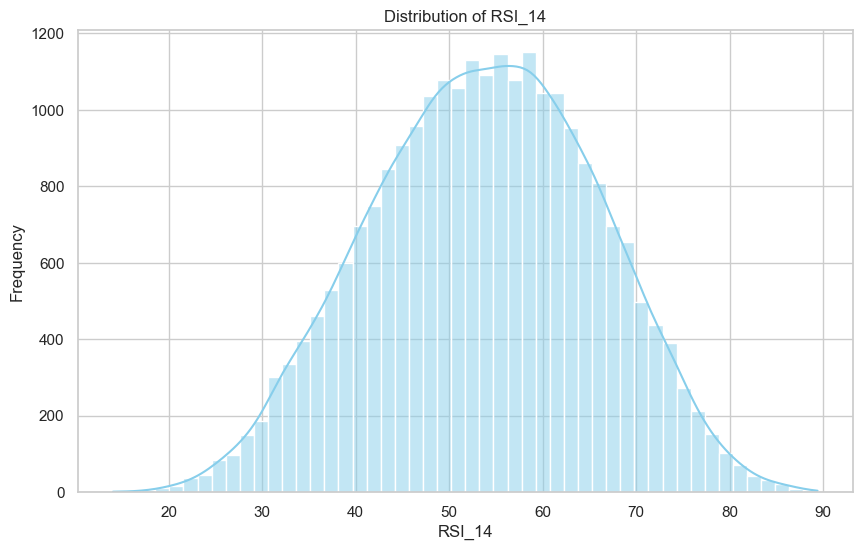

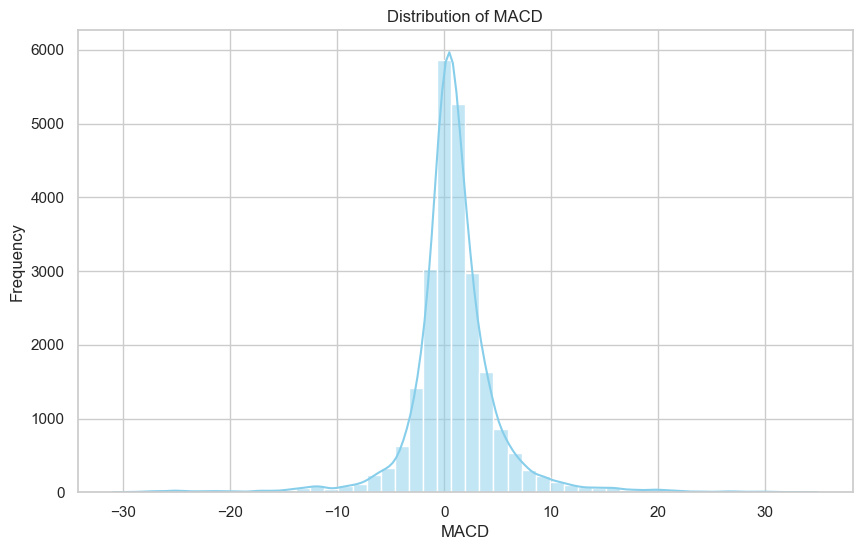

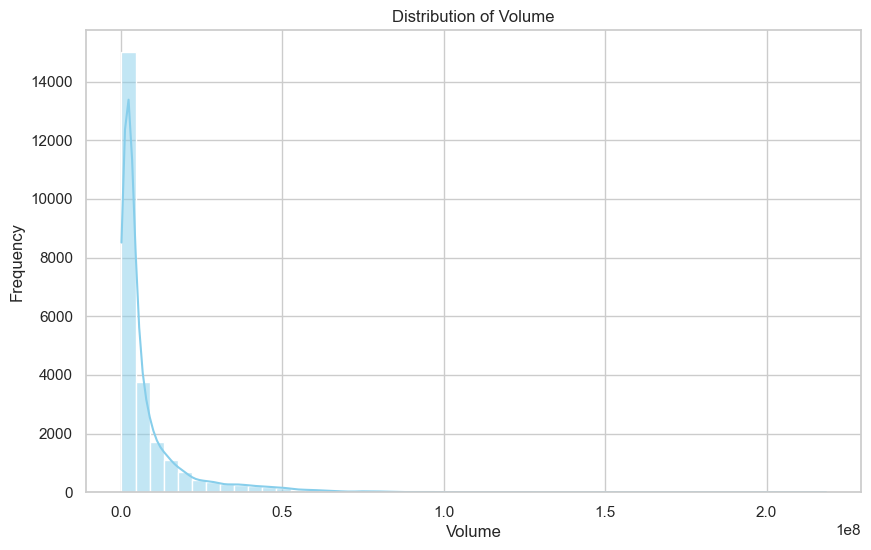

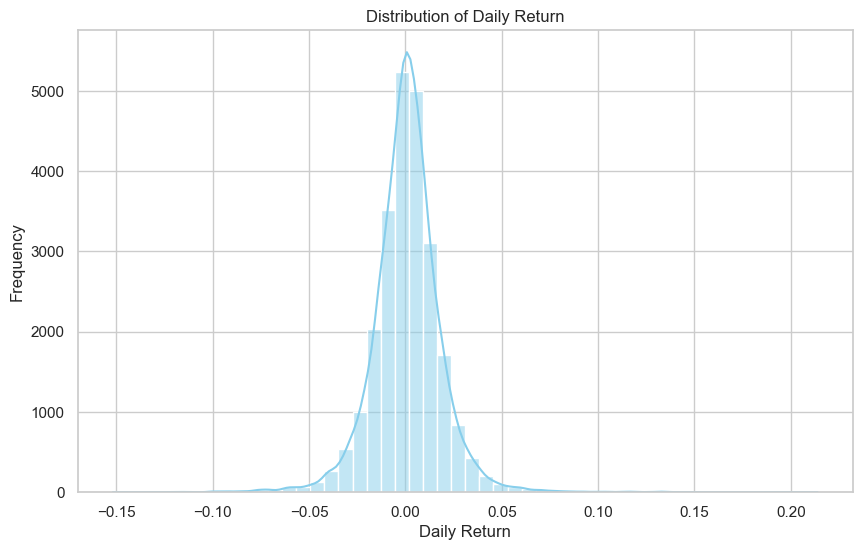

In [25]:
plot_distribution(banksfin_df, 'RSI_14')
plot_distribution(banksfin_df, 'MACD')
plot_distribution(banksfin_df, 'Volume')
plot_distribution(banksfin_df, 'Daily Return')

#### 4) Generate a Correlation Heatmap to Spot Redundant Features
Highly correlated features can be redundant and may hurt certain models. Use a heatmap to visually inspect correlation between numerical features.
- **Resource**: [5 Minute EDA: Correlation Heatmap](https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14)

In [27]:
# Select only numeric columns
numeric_df = banksfin_df.select_dtypes(include=['float64', 'int64'])

# Drop rows with missing values (optional, but avoids NaNs in heatmap)
numeric_df = numeric_df.dropna()

# Compute correlation matrix
corr_matrix = numeric_df.corr()

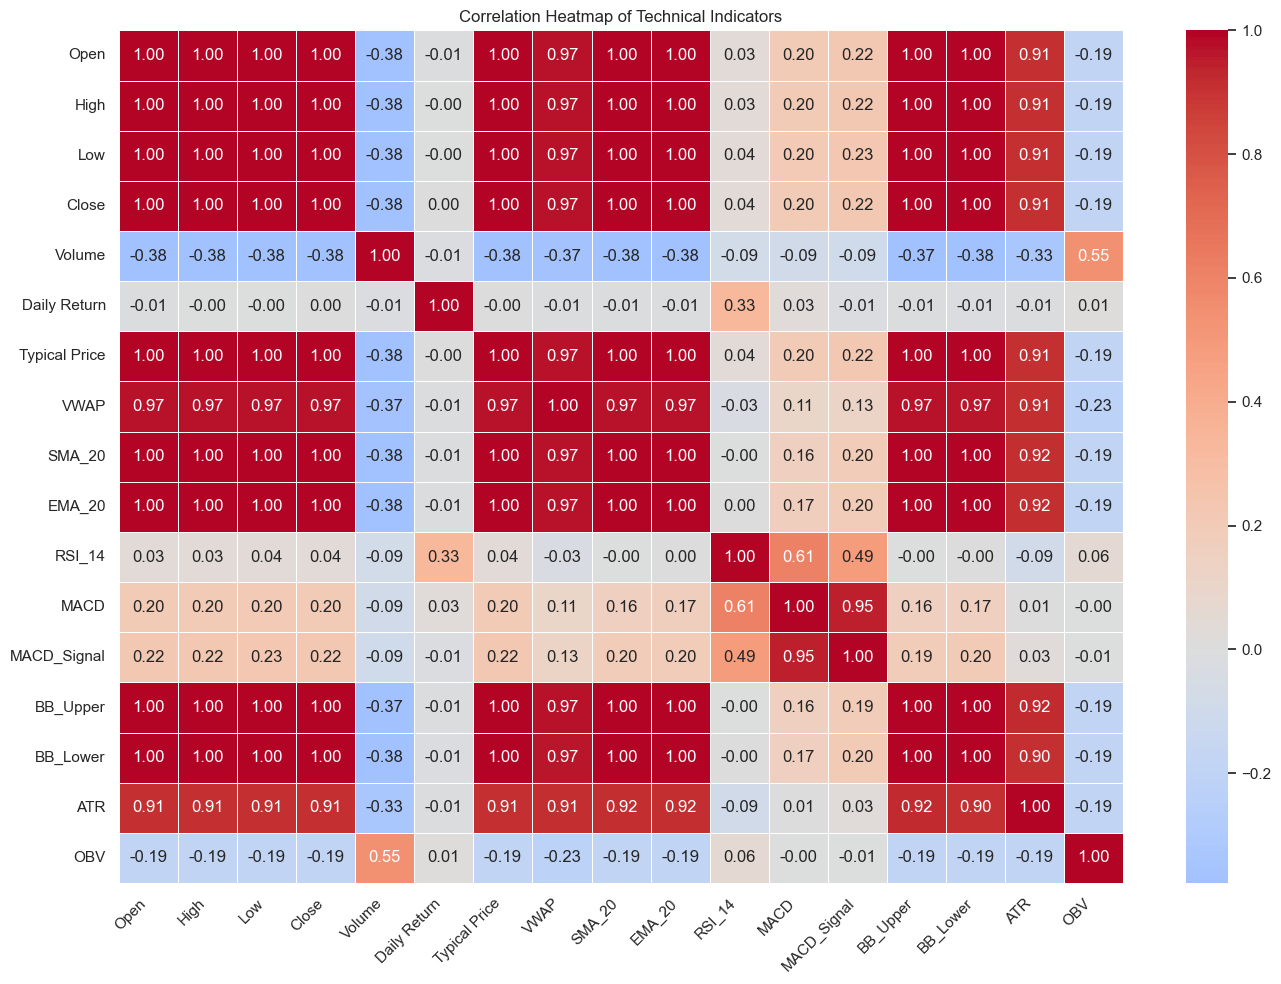

In [29]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap of Technical Indicators")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 5) Check the Relationship Between Features and the Target
Explore how technical indicators relate to the target (next day’s close). Use scatter plots or group-by summaries to spot patterns.
- **Resource**: [Scatter plot with a grouping variable with Pandas](https://python-graph-gallery.com/537-scatter-plots-grouped-by-color-with-pandas/)

In [31]:
banksfin_df['Next_Close'] = df.groupby('Ticker')['Close'].shift(-1)

In [33]:
def plot_feature_vs_target(df, feature, target='Next_Close'):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=df[target])
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)
    plt.show()

<Figure size 800x600 with 0 Axes>

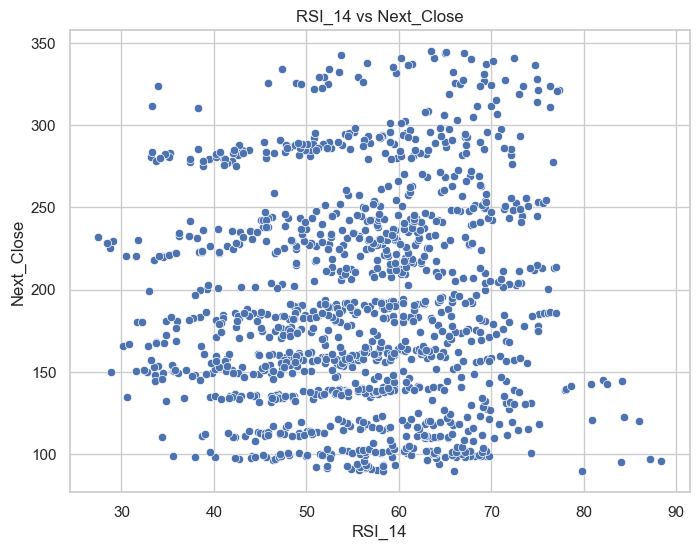

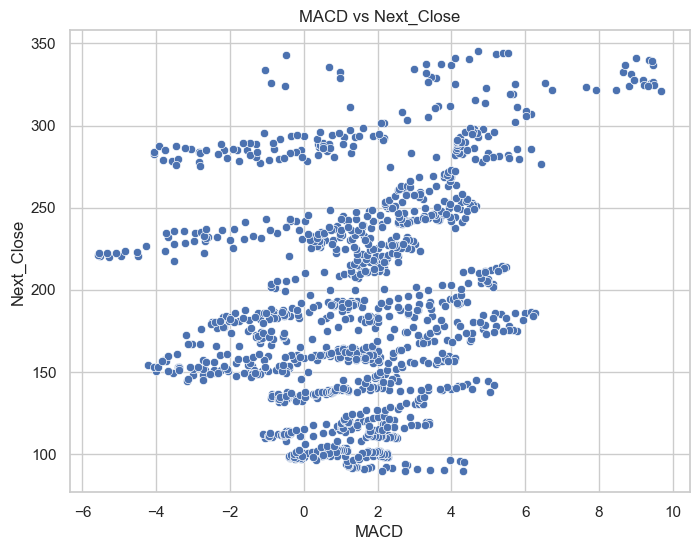

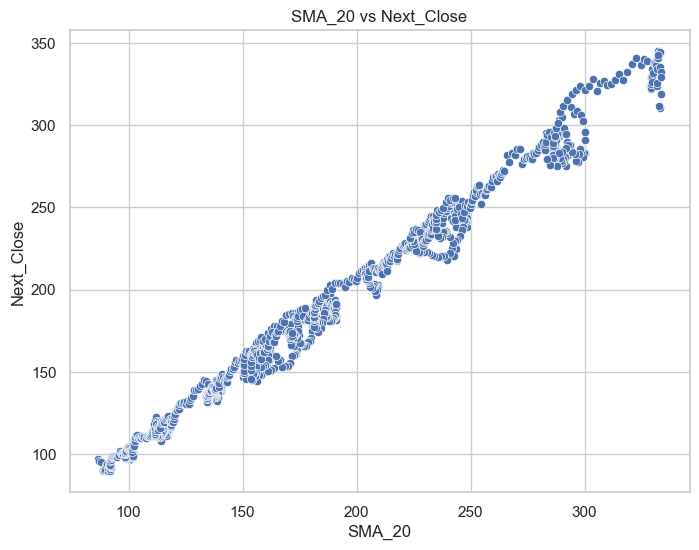

In [37]:
plot_feature_vs_target(banksfin_df, 'RSI_14')
plot_feature_vs_target(banksfin_df, 'MACD')
plot_feature_vs_target(banksfin_df, 'SMA_20')

C:\Users\sarah\AppData\Local\Temp\ipykernel_7816\1259372271.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = banksfin_df.groupby('RSI_Bin')['Next_Close'].mean()


RSI_Bin
(14.038, 45.13]     188.504365
(45.13, 53.974]     185.939142
(53.974, 62.423]    191.428024
(62.423, 89.417]    197.542479
Name: Next_Close, dtype: float64


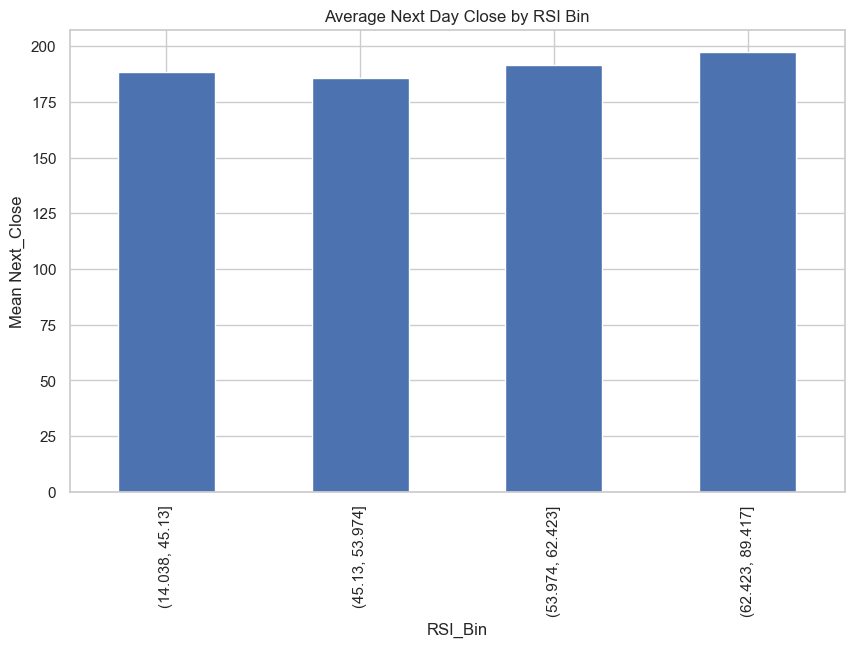

In [43]:
# Bin RSI into quantiles
banksfin_df['RSI_Bin'] = pd.qcut(banksfin_df['RSI_14'], q=4)

# Compute mean next-day return for each bin
grouped = banksfin_df.groupby('RSI_Bin')['Next_Close'].mean()

print(grouped)
grouped.plot(kind='bar', title='Average Next Day Close by RSI Bin')
plt.ylabel('Mean Next_Close')
plt.show();

In [45]:
# Drop NaNs before calculating correlation
target_corr = banksfin_df[['Next_Close', 'RSI_14', 'MACD', 'MACD_Signal', 'Volume', 'ATR', 'OBV']].dropna().corr()

# Correlation with target
print(target_corr['Next_Close'].sort_values(ascending=False))

Next_Close     1.000000
OBV            0.949677
ATR            0.795572
MACD_Signal    0.278752
MACD           0.268520
Volume         0.154864
RSI_14         0.062050
Name: Next_Close, dtype: float64


#### 6) Use Boxplots to Detect Outliers
- Boxplots are a great way to spot extreme values or outliers in numeric features. 
- Outliers can influence your model heavily — decide whether to keep, remove, or transform them.
- **Resource**: [How to detect outliers using IQR and Boxplots?](https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-using-iqr-and-boxplots/)

In [47]:
def plot_boxplot(df, column):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.grid(True)
    plt.show()

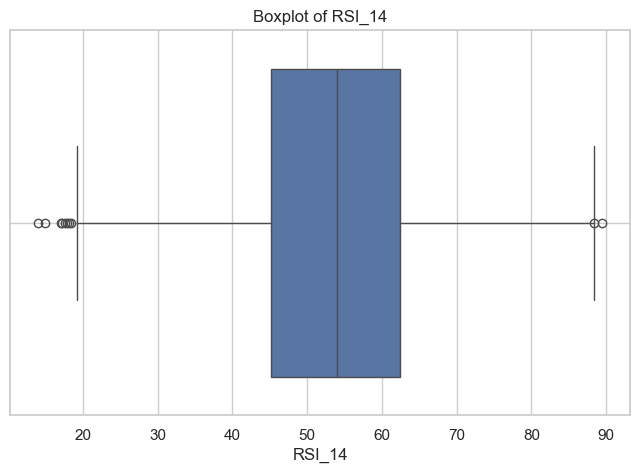

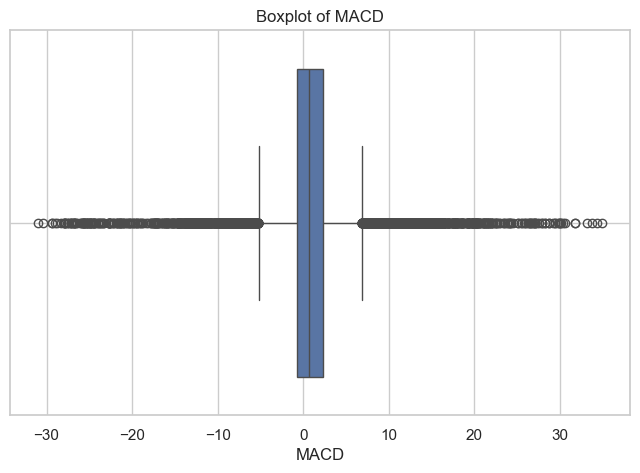

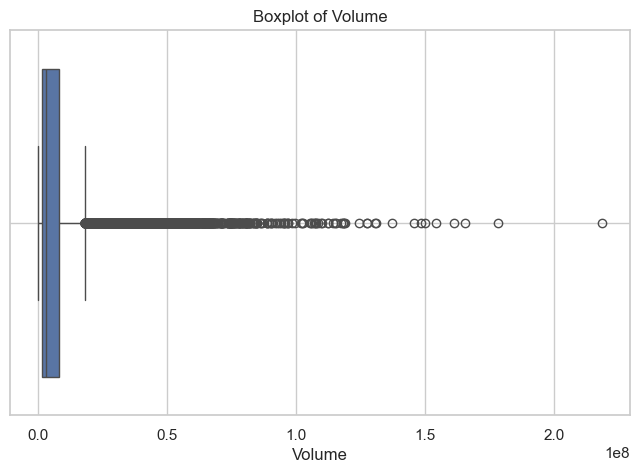

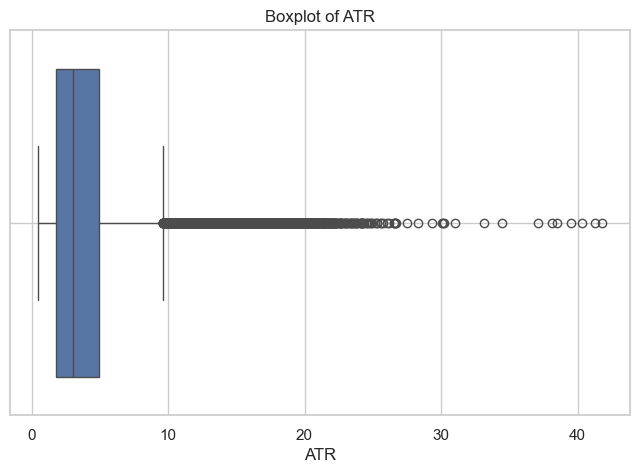

In [49]:
plot_boxplot(banksfin_df, 'RSI_14')
plot_boxplot(banksfin_df, 'MACD')
plot_boxplot(banksfin_df, 'Volume')
plot_boxplot(banksfin_df, 'ATR')

In [51]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

In [53]:
outliers_rsi = detect_outliers_iqr(banksfin_df, 'RSI_14')
print(f"Outliers in RSI_14: {len(outliers_rsi)}")

Outliers in RSI_14: 10


#### 7) Investigate Patterns Over Time or Between Groups (Sector, Ticker, etc.)
- Use time-based plots to see if the target or indicators change by day of the week or over time.
- Grouped boxplots can help reveal differences between companies or sectors.
- **Resource**: [Python Plotting for Exploratory Data Analysis](https://pythonplot.com/)

In [55]:
def plot_time_series(df, ticker, feature):
    df_ticker = df[df["Ticker"] == ticker]
    plt.figure(figsize=(12, 5))
    sns.lineplot(x="Date", y=feature, data=df_ticker)
    plt.title(f"{feature} over Time for {ticker}")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

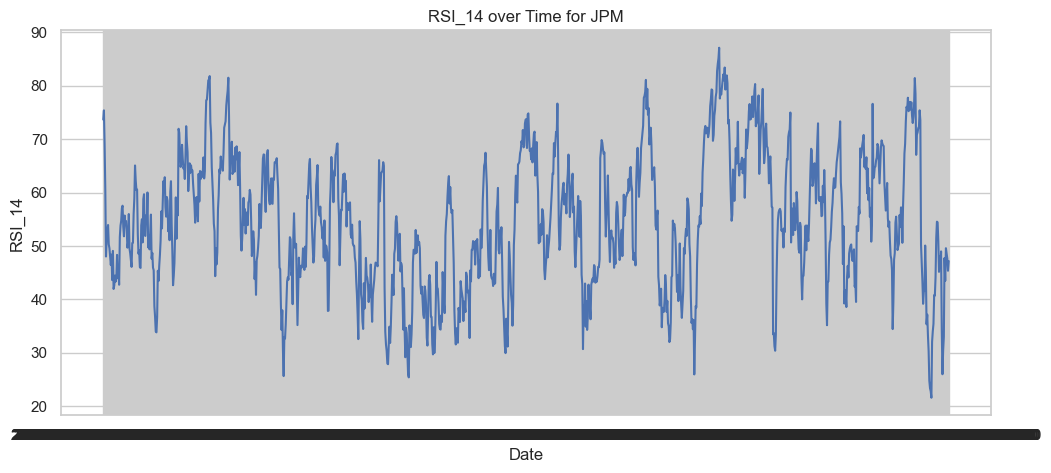

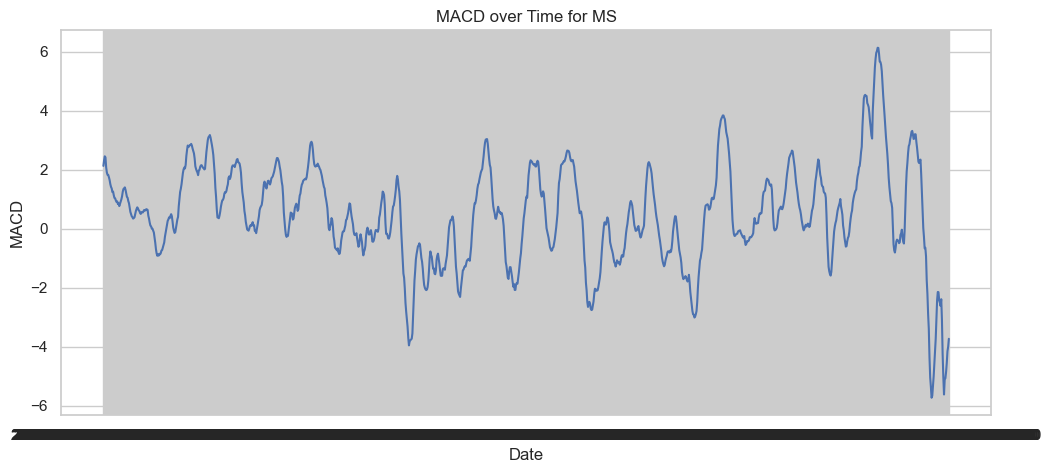

In [60]:
plot_time_series(banksfin_df, "JPM", "RSI_14")
plot_time_series(banksfin_df, "MS", "MACD")

In [62]:
banksfin_df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.day_name()

<Figure size 1000x600 with 0 Axes>

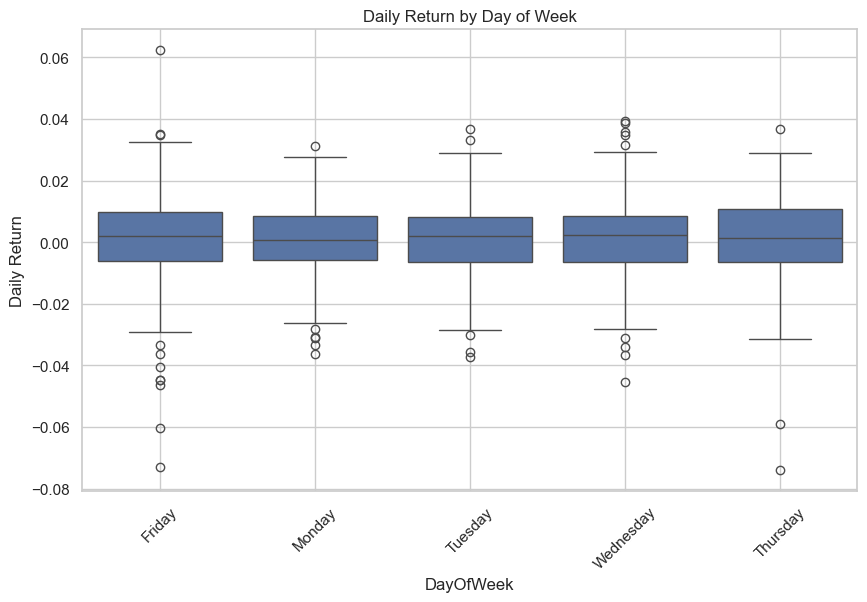

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Daily Return', data=banksfin_df)
plt.title("Daily Return by Day of Week")
plt.xticks(rotation=45)
plt.grid(True)
plt.show();

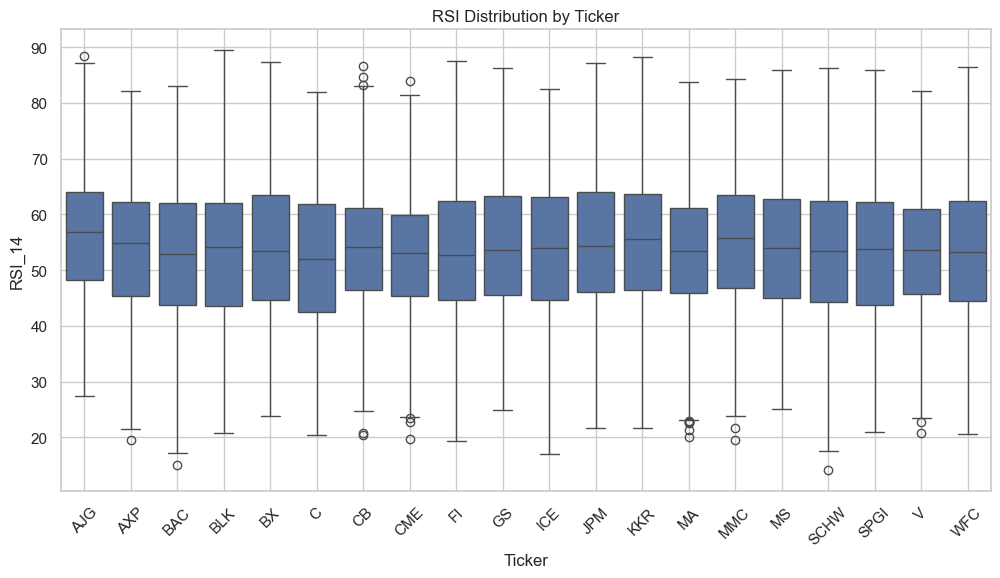

In [68]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Ticker", y="RSI_14", data=banksfin_df)
plt.title("RSI Distribution by Ticker")
plt.xticks(rotation=45)
plt.grid(True)
plt.show();

#### 8) Brainstorm & Engineer New Features Based on Your Insights
- Consider creating features like price range, volatility, lagged prices, or differences from moving averages.
- These can help capture patterns not directly visible in raw features.
- **Resource**: [A Reference Guide to Feature Engineering](https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods)